In [1]:
!pip install captum

     |████████████████████████████████| 4.4 MB 1.4 MB/s eta 0:00:01


# Exploration of the Captum Package

Captum is a model interpretability and understanding library for PyTorch

In [1]:
import numpy as np
import torch
from muzero_model.utils import load_saved_model, load_saved_model_only
from muzero_model.models import Nets, Alphazero_wrapper
from muzero_model.breakthrough import State, Board
from muzero_model.mcts import Tree

from utils import get_image_array
import matplotlib.pyplot as plt

model_path = '../muzero_model/model_checkpoints/alpha_v04/models/alpha_v04_model_0000632032_ep_20210528_094613.pkl'
nets = Alphazero_wrapper(num_blocks = 5,num_filters = 64)
model = load_saved_model_only(model_path, nets)

def single_output_forward(out_ind):
    """
    This is an "hack" to be able to use the Captum package with models with multiple outputs
    """
    def forward(x):
        yhat = model.prediction(x)
        return yhat[out_ind]
    return forward

from stored_games import *

import numpy as np

import torch
import torch.nn as nn

from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    Saliency,
    Occlusion,
    Lime,
    ShapleyValueSampling,
    ShapleyValues,
    FeatureAblation,
    GuidedGradCam
)

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
model.eval()

class single_output_forward_class(nn.Module):
    def __init__(self,
                model,
                out_ind):
        super(single_output_forward_class, self).__init__()
        self.model = model
        self.out_ind = out_ind
        
    def forward(self, x):
        yhat = self.model.prediction(x)
        return yhat[self.out_ind]

single_output_model = single_output_forward_class(model, 1)


tree = Tree(nets)


In [3]:

state = State()
chosen_game = game_01

for move in chosen_game:
    state.board = state.board.move(move[0], move[1], move[2], move[3])

In [51]:
grid = np.array([[2, 2, 0, 2, 0],
                [2, 2, 2, 2, 2],
                [1, 0, 0, 0, 1],
                [0, 1, 0, 1, 0],
                [0, 1, 1, 1, 0],
                [1, 1, 1, 1, 1]])
player_to_move = 1

board = Board(5, grid)
state = State(board=board, player_to_move = player_to_move)

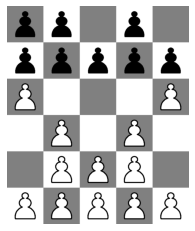

In [52]:

    
input = state.feature()
baseline = np.ones_like(input)/2

input = torch.from_numpy(input).unsqueeze(0).float()
baseline = torch.from_numpy(baseline).unsqueeze(0).float()
input.requires_grad = True

im = get_image_array(state)
plt.imshow(im)
plt.axis('off')
plt.show()

In [53]:
def show_mat(mat, state, title = None, show_title = True, save = False):
    img = get_image_array(state)
    
    cmap = 'Blues_r'
    
    fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2, figsize = (6,6))
    if title:
        if show_title:
            fig.suptitle(title, fontsize=15)
    vmin = mat.min()
    vmax = mat.max()
    ax0.imshow(img)
    ax0.axis('off')
    player = 'WHITE' if state.player_to_move == 1 else 'BLACK'
    ax0.set_title(player + ' to move')
    
    im = ax1.imshow(mat[0], vmin=vmin, vmax=vmax, cmap = cmap)
    ax1.set_title('Active Player')
    im = ax2.imshow(mat[1], vmin=vmin, vmax=vmax, cmap = cmap)
    ax2.set_title('Opponent')
    im = ax3.imshow(mat[2], vmin=vmin, vmax=vmax, cmap = cmap)
    ax3.set_title('Color Layer')
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    if save:
        plt.savefig(title+'.png')
    plt.show()

# Saliency

The saliency method computes gradients with respect to the chosen target

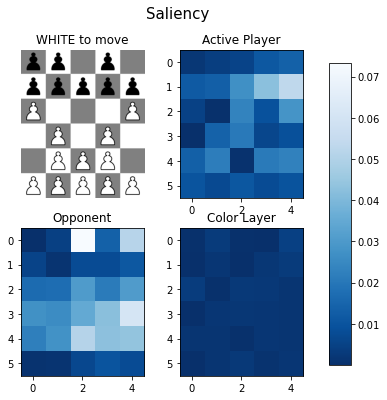

In [54]:
ig = Saliency(single_output_model)
attributions = ig.attribute(input, target=0)
mat = attributions.numpy().squeeze(0)
show_mat(mat, state, title = 'Saliency')

# IntegratedGradients

Integrated Gradients computes the integral of the gradients of the output prediction for the class index ind with respect to the input image pixels.
More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

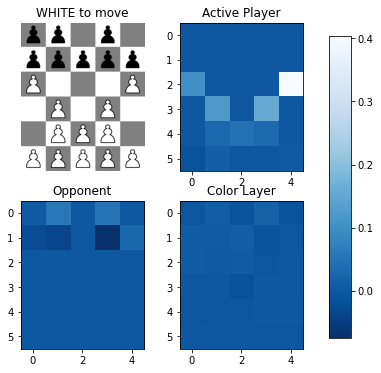

In [55]:
ig = IntegratedGradients(single_output_model)
attributions, delta = ig.attribute(input, baseline*0, target=0, return_convergence_delta=True)
mat = attributions.detach().numpy().squeeze(0)
show_mat(mat, state, title = 'IntegratedGradients', save = True, show_title=False)

# NoiseTunnel

Noise tunnel with smoothgrad square option adds gaussian noise with a standard deviation of stdevs=0.2 to the input image nt_samples times, computes the attributions for nt_samples images and returns the mean of the squared attributions across nt_samples images.

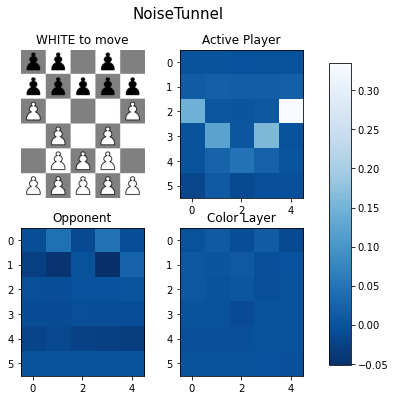

In [57]:
ig = IntegratedGradients(single_output_model)
nt = NoiseTunnel(ig)
attributions, delta = nt.attribute(input, nt_type='smoothgrad', stdevs=0.3, n_samples=100,
      baselines=baseline*0, target=0, return_convergence_delta=True)
#attributions, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)
mat = attributions.numpy().squeeze(0)
show_mat(mat, state, title = 'NoiseTunnel')

# DeepLift

Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.

/home/ap/anaconda3/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/ap/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


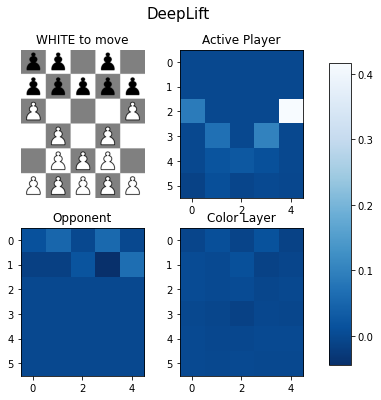

In [58]:
dl = DeepLift(single_output_model)
attributions = dl.attribute(input, baseline*0)
mat = attributions.detach().numpy().squeeze(0)
show_mat(mat, state, title = 'DeepLift')

# GradientShap
GradientShap, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

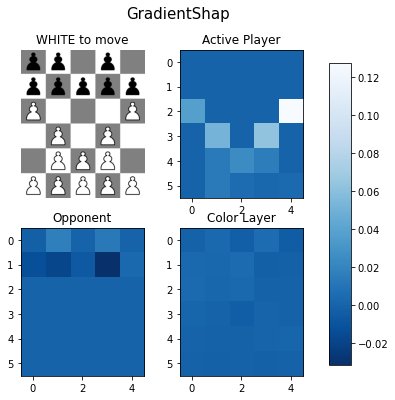

In [59]:
gradient_shap = GradientShap(single_output_model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=0)
mat = attributions.detach().numpy().squeeze(0)
show_mat(mat, state, title = 'GradientShap')

# Occlusion

Occlusion is a perturbation based approach to compute attribution, involving replacing each contiguous rectangular region with a given baseline / reference, and computing the difference in output. For features located in multiple regions (hyperrectangles), the corresponding output differences are averaged to compute the attribution for that feature.

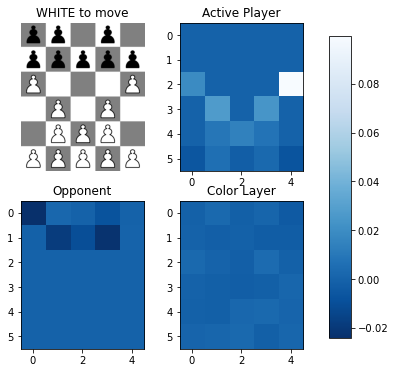

In [69]:
occlusion = Occlusion(single_output_model)

attributions = occlusion.attribute(input,
                                       strides = (1,1,1),
                                       target=0,
                                       sliding_window_shapes=(1,1, 1),
                                       baselines=baseline*0)
mat = attributions.detach().numpy().squeeze(0)
show_mat(mat, state, title = 'Occlusion', save = True, show_title=False)

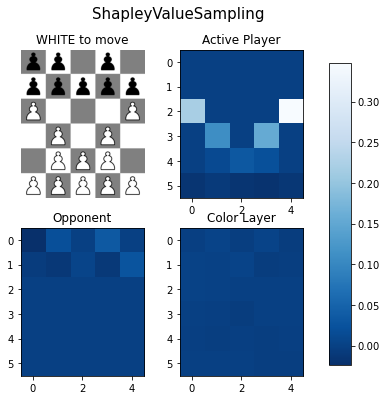

In [70]:
svs = ShapleyValueSampling(single_output_model)

attributions = svs.attribute(input,
                             target=0,
                             n_samples=200)
mat = attributions.detach().cpu().numpy().squeeze(0)
show_mat(mat, state, title = 'ShapleyValueSampling')

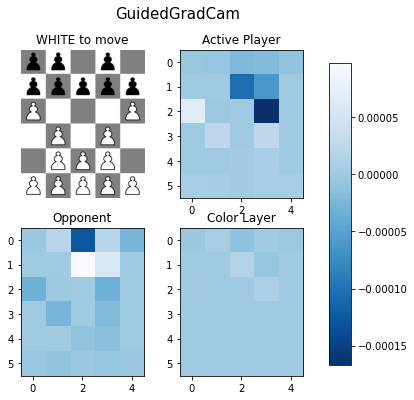

In [74]:
ggc = GuidedGradCam(single_output_model, model.prediction.res_blocks[3].block[0])

attributions = ggc.attribute(input,
                             target=0)
mat = attributions.detach().numpy().squeeze(0)
show_mat(mat, state, title = 'GuidedGradCam')

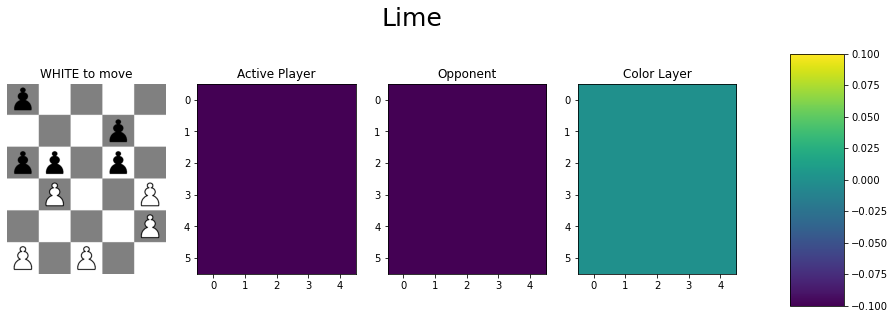

In [239]:
numpy_arr = np.array(list(range(len(input.flatten())))).reshape(input.shape)
feature_mask = torch.from_numpy(numpy_arr).long()

def perturb_func(
    original_input: Tensor,
    **kwargs)->Tensor:
    return original_input + torch.randn_like(original_input)

def similarity_kernel(
    original_input: Tensor,
    perturbed_input: Tensor,
    perturbed_interpretable_input: Tensor,
    **kwargs)->Tensor:
        # kernel_width will be provided to attribute as a kwarg
        kernel_width = kwargs.get("kernel_width",0.5)
        l2_dist = torch.norm(original_input - perturbed_input)
        return torch.exp(- (l2_dist**2) / (kernel_width**2))


lime = Lime(single_output_model, similarity_func = similarity_kernel)
attributions = lime.attribute(input, target=0, baselines = baseline, n_samples=1000, feature_mask=feature_mask)
mat = attributions.detach().numpy().squeeze(0)
show_mat(mat, state, title = 'Lime')